# Conformaciones con mejor AUC
**Evaluación de conformaciones de CDK2 según su valor de AUC con el dataset CSAR**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

Carga de los datos.

In [2]:
# Carga y muestra de los datos
data_dir = './B_DATOS'
df_cdk2_labels = pd.read_json(F"{data_dir}/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS_AUC_docking.json")
df_cdk2_labels.iloc[: , -8:].head(5)

,Inhib,Inhib_mass,Labels_conf,AUC_vrd_16x,AUC_vrd_8x,AUC_vina,AUC_ad4_LC,AUC_ad4_LE
1aq1,STU,440.0,inact_b,0.730317,0.740724,0.575339,0.634163,0.572172
1b38,ATP,398.0,inact_a,0.677828,0.683258,0.546154,0.571946,0.483032
1b39,ATP,398.0,inact_a,0.764706,0.785520,0.580543,0.670814,0.607919
1buh,,,inact_a,0.708145,0.734163,0.535294,0.613348,0.544344
1ckp,PVB,214.0,inact_a,0.766968,0.781900,0.571493,0.764932,0.715385


## Correlación de los rankings

Para obtener la correlación de los valores:

In [3]:
# Seleccionamos las columnas que poseen los scores para cada método usado
df_auc_scores = df_cdk2_labels[['AUC_ad4_LE', 'AUC_ad4_LC', 
                'AUC_vina', 'AUC_vrd_8x', 'AUC_vrd_16x']]
df_auc_scores.shape

(402, 5)

In [4]:
# Correlación de Pearson
mtx_cor_pearson = df_auc_scores.corr(method = 'pearson')
# Correlación de Spearman
mtx_cor_sepearman = df_auc_scores.corr(method = 'spearman')

### Correlación de Pearson

In [5]:
mtx_cor_pearson

,AUC_ad4_LE,AUC_ad4_LC,AUC_vina,AUC_vrd_8x,AUC_vrd_16x
AUC_ad4_LE,1.000000,0.897545,0.292637,0.616034,0.620263
AUC_ad4_LC,0.897545,1.000000,0.268382,0.624657,0.631929
AUC_vina,0.292637,0.268382,1.000000,0.531182,0.523890
AUC_vrd_8x,0.616034,0.624657,0.531182,1.000000,0.955277
AUC_vrd_16x,0.620263,0.631929,0.523890,0.955277,1.000000


### Correlación de  Spearman

In [6]:
mtx_cor_sepearman

,AUC_ad4_LE,AUC_ad4_LC,AUC_vina,AUC_vrd_8x,AUC_vrd_16x
AUC_ad4_LE,1.000000,0.905884,0.273622,0.615868,0.617034
AUC_ad4_LC,0.905884,1.000000,0.265574,0.642429,0.647881
AUC_vina,0.273622,0.265574,1.000000,0.520171,0.494863
AUC_vrd_8x,0.615868,0.642429,0.520171,1.000000,0.950113
AUC_vrd_16x,0.617034,0.647881,0.494863,0.950113,1.000000


#### Valores *p* correspondientes
Para extraer los **valores p**, usaremos _scipy_.

> - **_H0_**: El coeficiente de correlación ($\rho$) NO es diferente de 0 (muestras son independientes)
- **_Ha_**: $\rho$ es distinto de cero (Muestras dependientes/ correlacionadas)

In [7]:
# Extraemos el valor de correlación y el valor p entre cada par
n_values = df_auc_scores.shape[1]
# Creamos las matrices vacias
mtx_pearson_p = np.zeros((n_values, n_values))
mtx_spearman_p = np.zeros((n_values, n_values))
for i, i_data in enumerate(df_auc_scores):
    for j, j_data in enumerate(df_auc_scores):
        # Cálculo de Pearson
        r_P, p_P = stats.pearsonr(df_auc_scores[i_data], df_auc_scores[j_data])
        mtx_pearson_p[i, j] = p_P
        # Cálculo de Pearson
        r_S, p_S = stats.spearmanr(df_auc_scores[i_data], df_auc_scores[j_data])
        mtx_spearman_p[i, j] = p_S

Verificamos que los valores de correlación sean significativos

In [8]:
print(mtx_pearson_p.all() < 0.05)
print(mtx_spearman_p.all() < 0.05)
# Todos los valores p son menores a alfa = 0.05

True
True


**Todos los valores de correlación son significativos (p < 0.05).**

## Gráfica de las correlaciones

In [9]:
import seaborn as sns
%matplotlib inline
sns.set(context = 'notebook', style = 'white', font_scale=1.2)

### Pairplot

In [10]:
# Añadimos una etiqueta a las conformaciones tal que podamos distinguir las activas de las inactivas
# Creamos las etiquetas
labels_actives = ['CDK2 Activa' if i == 'active' else 'CDK Inactiva' for i in df_cdk2_labels.Labels_conf]
# La añadimos al dataframe
df_auc_scores_labels = df_auc_scores.copy()
df_auc_scores_labels['Labels'] = labels_actives

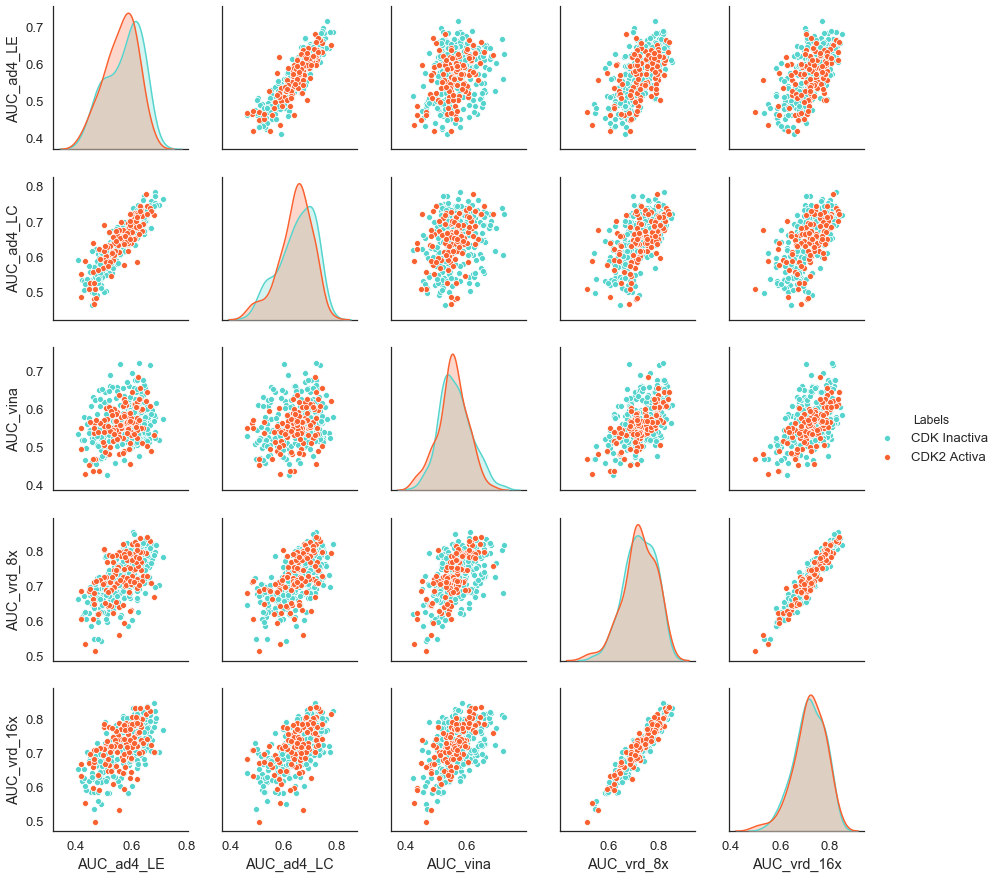

In [11]:
#plt.figure(figsize=(10, 10))
cmp_pairs = sns.color_palette(["#55D4CE", "#FA6130"])
pair_plot = sns.pairplot(df_auc_scores_labels, hue = 'Labels', palette = cmp_pairs)
pair_plot;

> **La etiqueta del tipo de conformación no permite visualizar ningun patrón, no obstante quizá con posteriores análisis podamos identificar patrones en las conformaciones con mejor AUC, que permitan visualizar una distinción de éstas con respecto a las conformaciones con menor AUC.**

#### PENDIENTE:
Verificar si el volumen, la forma del pocket, un subconjunto de residuos de la proteína o quizá alguna otra característica de éstas permiten determinar qué las hace buenas para haber mejorado el ranking.

# Frente de Pareto
### Función para identificar las conformaciones del frente no dominado

In [12]:
def pareto_front(scores):
    ''' Función para determinar si una observación pertenece 
    al frente no dominado dado un arreglo de n_observaciones, 
    y m_scores de las funciones objetivo.
    '''
    # Se crea un arreglo inicial de tamaño igual al número de observaciones
    # Todos los elementos se inicializan como parte del frente no dominado ( = 1)
    pareto_front = np.ones(scores.shape[0], dtype = bool)
    # Se itera sobre cada observación
    for i, s in enumerate(scores):
        # Comprueba si el punto i domina a los demás elementos
        if not np.all(np.any(scores[i] > scores[:i], axis=1)): # Para elementos 
            pareto_front[i] = 0
            continue
        if not np.all(np.any(scores[i] > scores[i+1:], axis=1)):
            pareto_front[i] = 0
    return pareto_front

Recordar que en el dataframe `df_auc_scores` tenemos los AUC de los diferentes métodos de acomplamiento/scores.

In [13]:
# Función para generar un Frente de pareto con sólo dos funciones objetivo a modo de ejemplo
# Generamos un arreglo de numpy con los scores deseados
cmp_pareto = sns.color_palette(["#50DAB4", "#FA5F50"])

def plot_pair_pareto(metodos, cmp = cmp_pareto):
    scores = df_auc_scores[ metodos ].to_numpy() # Se convierte el DataFrame a matriz de numpy
    pareto_points = pareto_front(scores) # Se calculan lso scores
    df_pareto = df_auc_scores[pareto_points]
    # Graficamos
    plt.figure(figsize=(6, 6))
    sns.lineplot(df_pareto[metodos[0]], df_pareto[metodos[1]])
    sns.scatterplot(df_auc_scores[metodos[0]], df_auc_scores[metodos[1]], 
                    hue=pareto_points, s=75, palette= cmp)
    return(df_pareto[metodos])

### Primer ejemplo:
    - AUC de vinardo 8x
    - AUC de AD4 LC

,AUC_vrd_8x,AUC_ad4_LC
1h07,0.819683,0.784842
1urw,0.851584,0.722172
4cfn,0.826244,0.738914
4eor,0.836878,0.729864


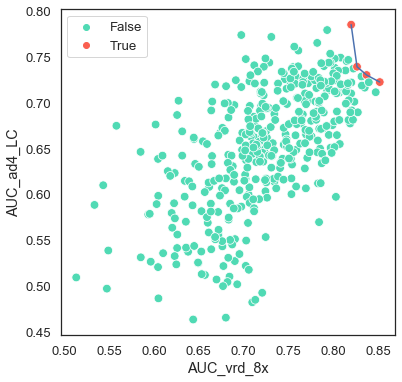

In [14]:
# Generamos un arreglo de numpy con los scores deseados
metodos = ['AUC_vrd_8x', 'AUC_ad4_LC']
plot_pair_pareto(metodos)

### Segundo ejemplo:
    - AUC de vinardo 8x
    - AUC de vinardo |6x

,AUC_vrd_8x,AUC_vrd_16x
1urw,0.851584,0.831674
2r3p,0.834842,0.839819
2vv9,0.815837,0.848643
6guf,0.839367,0.836878


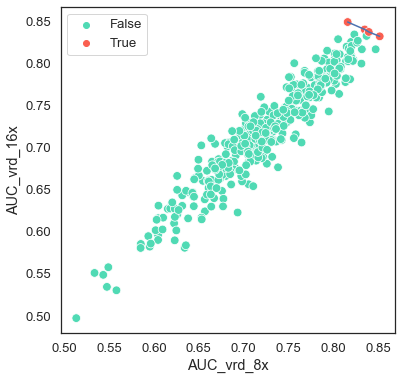

In [15]:
# Generamos un arreglo de numpy con los scores deseados
metodos = ['AUC_vrd_8x', 'AUC_vrd_16x']
plot_pair_pareto(metodos)

### Tercer ejemplo:
    - AUC de vina 16x
    - AUC de vinardo 16x

,AUC_vina,AUC_vrd_16x
1oiq,0.715385,0.811312
2r3p,0.605204,0.839819
2vv9,0.584163,0.848643
3unj,0.722172,0.807240
3unk,0.676697,0.817195
4bzd,0.675339,0.820362
6guf,0.644344,0.836878


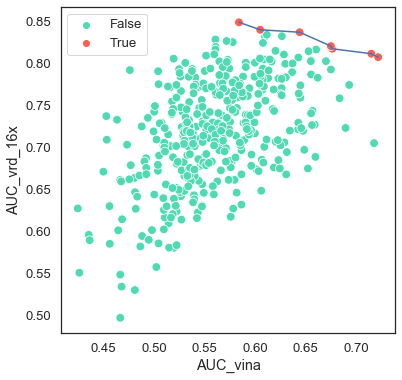

In [16]:
# Generamos un arreglo de numpy con los scores deseados
metodos = ['AUC_vina', 'AUC_vrd_16x']
plot_pair_pareto(metodos)

## Todos los scores (5 objetivos)
### Conformaciones en el frente no dominado

Si utilizamos los cinco métodos.

In [17]:
# Generamos un arreglo de numpy con los scores deseados
#scores = df_auc_scores[['AUC_vrd_8x', 'AUC_vrd_16x']].to_numpy()
scores = df_auc_scores.to_numpy()
pareto_points = pareto_front(scores)
confs = df_auc_scores[pareto_points].index
print(F'Número de conformaciones el el frente no dominado: {len(confs)}')
confs

Número de conformaciones el el frente no dominado: 25


Index(['1ckp', '1h07', '1ke9', '1oiq', '1pxm', '1urw', '1vyz', '2c4g', '2r3p',
       '2r64', '2vv9', '2w05', '3eid', '3ezv', '3lfn', '3qu0', '3s0o', '3s2p',
       '3unj', '3unk', '4bzd', '4cfn', '4eor', '4fkq', '6guf'],
      dtype='object')

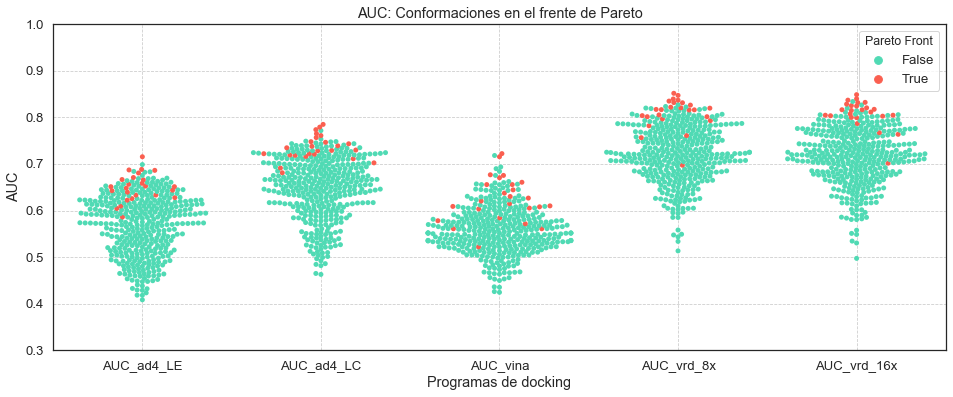

In [18]:
fig, axes = plt.subplots()

data = df_auc_scores
data = data.melt()
data['Pareto Front'] = np.tile(pareto_points, 5)

fig.set_size_inches(16, 6)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes,hue = "Pareto Front", palette= cmp_pareto)
axes.set_title('AUC: Conformaciones en el frente de Pareto')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking"); plt.ylabel("AUC"); plt.ylim(0.3, 1)
plt.show()

### Las conformaciones del frente considerando sólo vinardo (16x y 8x)

In [49]:
# Generamos un arreglo de numpy con los scores deseados
scores_vrd = df_auc_scores[['AUC_vrd_8x', 'AUC_vrd_16x']].to_numpy()
pareto_points_vrd = pareto_front(scores_vrd)
confs_vrd = df_auc_scores[pareto_points_vrd].index
print(F'Número de conformaciones el el frente no dominado: {len(confs_vrd)}')
df_cdk2_labels.index(df_cdk2_labels.loc[confs_vrd])

Número de conformaciones el el frente no dominado: 4


TypeError: 'Index' object is not callable

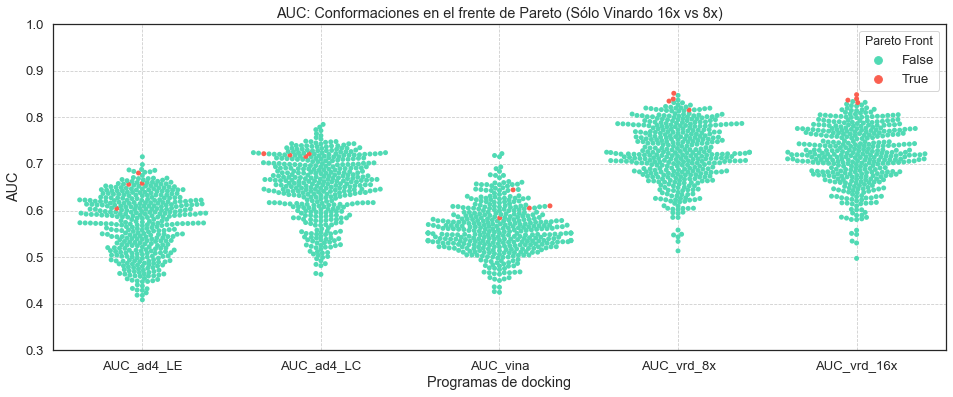

In [20]:
fig, axes = plt.subplots()

data = df_auc_scores
data = data.melt()
data['Pareto Front'] = np.tile(pareto_points_vrd, 5)

fig.set_size_inches(16, 6)
#sns.violinplot(x = "variable", y = "value", data= data, ax = axes, bw=.2, split=True, scale="count")
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, 
              hue = "Pareto Front", palette= cmp_pareto)
axes.set_title('AUC: Conformaciones en el frente de Pareto (Sólo Vinardo 16x vs 8x)')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking"); plt.ylabel("AUC"); plt.ylim(0.3, 1)
plt.show()

## Visualización el MDS, PCA y t-SNE

### Resultados POVME
#### Volumen de la cavidad por conformación

In [21]:
from modulos.plotting_functions import plot_mds, plot_points, plot_anotation_labels

In [35]:
# Cargamos los valores del volumen del pocket
col_names = ['frame', 'pocket_volume']
volumen_402_stc = pd.read_csv('../ARCHIVOS/CRISTALES/VOLUMEN/CDK2_VOL_RICCI_402/res_volumes.tabbed.txt', 
                              sep = "\t", header=None, names= col_names)
volumen_402_stc = volumen_402_stc.values.T

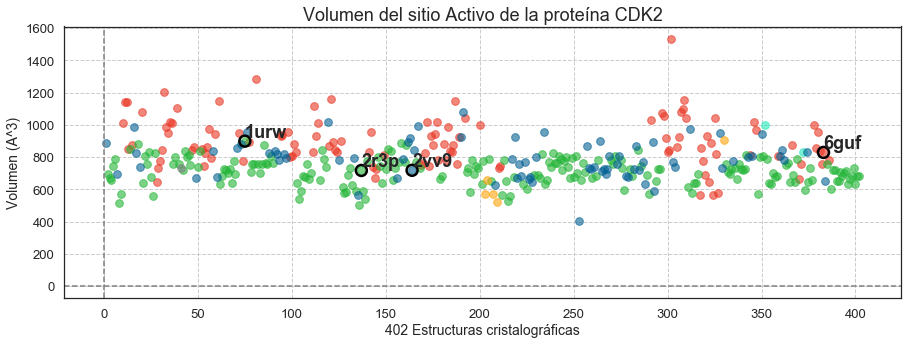

In [36]:
fig = plt.figure(figsize=(15, 5))
df_vol = volumen_402_stc
plot_points(df_vol, labels = df_cdk2_labels.Labels_conf,
                equal_axis=False, xlabel = "402 Estructuras cristalográficas", ylabel = "Volumen (A^3)", 
                title = "Volumen del sitio Activo de la proteína CDK2")
plot_anotation_labels(df_cdk2_labels.index, confs_vrd, 
                      df_vol[0], df_vol[1], xytext_delta=[0, 0], s=120)

#### MDS sobre matrices de similitud POVME
Las matrices de entrada para el cMDS son matrices de similitud utilizando el **índice de Tanimoto** para evaluar la presencia o ausencia de sondas entre cada par de pockets.

Al usar la función cMDS, la matriz de similitud $S$ es convertida a una matriz de disimilitud: $D = 1 - S$.

In [24]:
# Importamos las librerías necesarias creadas para calcular el MDS y graficar
from modulos.MDS import cMDS

In [25]:
# Directorio donde están guardados los resultados de POVME
dir_volumen_results = '../ARCHIVOS/CRISTALES/VOLUMEN/CDK2_VOL_RICCI_402/res_frameInfo/'

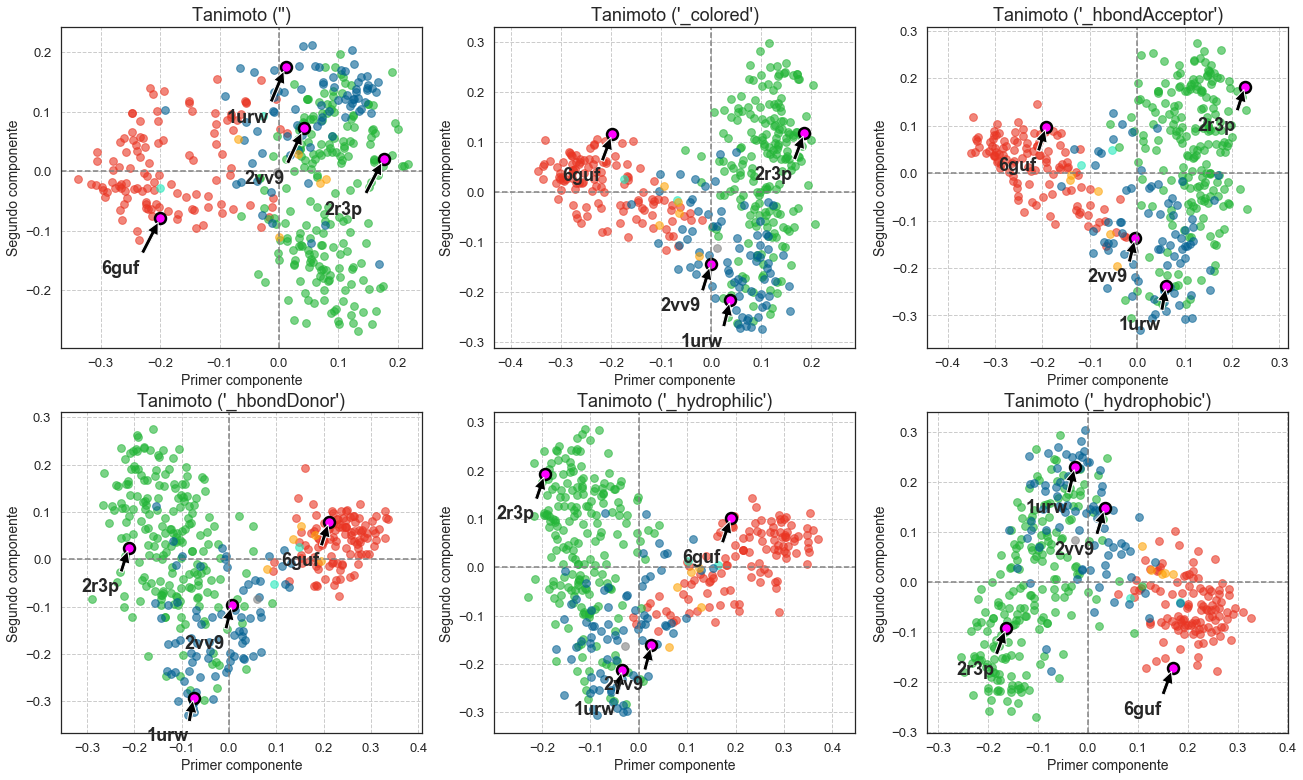

In [26]:
fig = plt.figure(figsize=(22, 13))
propiedades = ["", "_colored", "_hbondAcceptor", "_hbondDonor", "_hydrophilic", "_hydrophobic"]
for i, propiedad in enumerate(propiedades):
    # Cargamos la matriz de similitud
    tan_mtx = pd.read_csv(F'{dir_volumen_results}POVME_Tanimoto_matrix{propiedad}.csv', header=None)
    # Se calcula el cMDs de la propiedad
    mds = cMDS(tan_mtx, is_similarity = True) # Se convertirá a matriz de distancia
    plt.subplot(2, 3, i + 1)
    plot_mds(mds_obj = mds[0], titulo = F"Tanimoto ('{propiedad}')", 
             list_of_labels = df_cdk2_labels.Labels_conf, 
             key_structures= confs_vrd, df_conf_indexes = df_cdk2_labels.index)

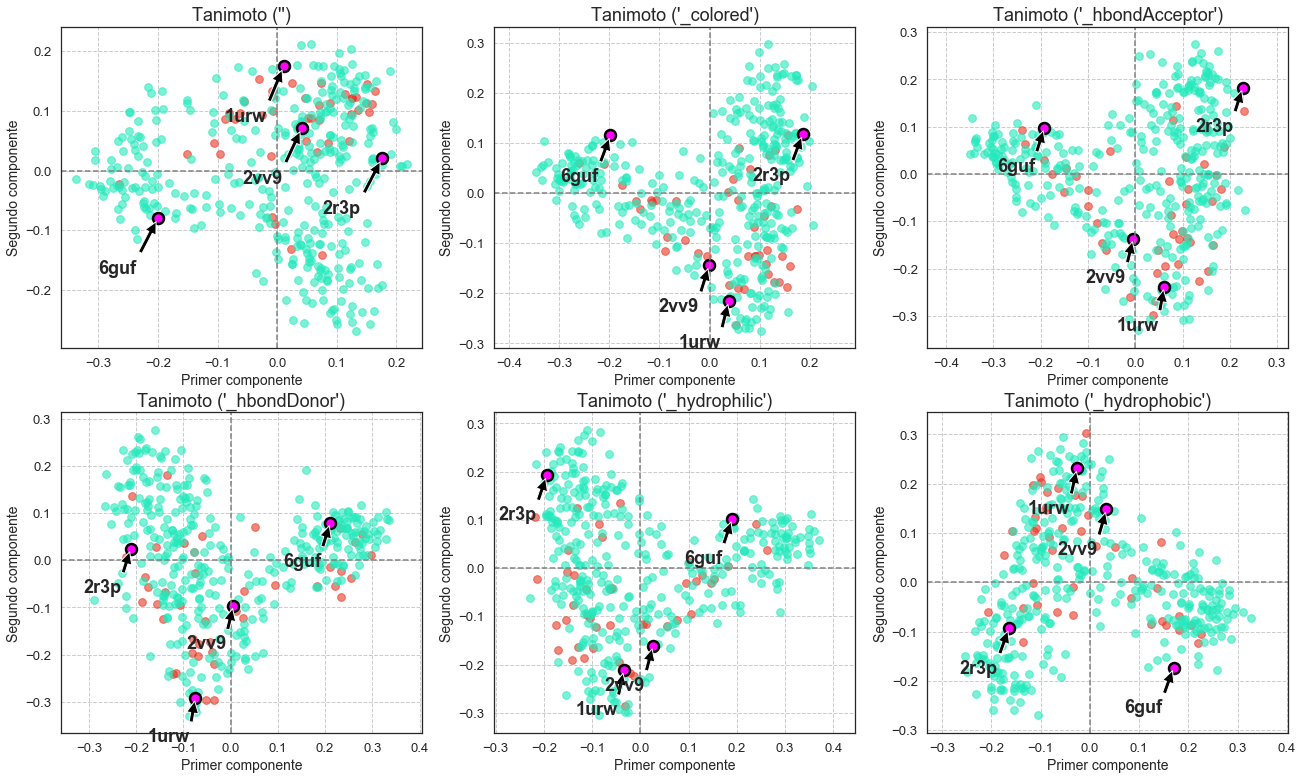

In [27]:
fig = plt.figure(figsize=(22, 13))

labels_vinardo = (df_cdk2_labels.AUC_vrd_8x < 0.8)

propiedades = ["", "_colored", "_hbondAcceptor", "_hbondDonor", "_hydrophilic", "_hydrophobic"]
for i, propiedad in enumerate(propiedades):
    # Cargamos la matriz de similitud
    tan_mtx = pd.read_csv(F'{dir_volumen_results}POVME_Tanimoto_matrix{propiedad}.csv', header=None)
    # Se calcula el cMDs de la propiedad
    mds = cMDS(tan_mtx, is_similarity = True) # Se convertirá a matriz de distancia
    plt.subplot(2, 3, i + 1)
    plot_mds(mds_obj = mds[0], titulo = F"Tanimoto ('{propiedad}')", list_of_labels = labels_vinardo, 
             key_structures= confs_vrd, df_conf_indexes = df_cdk2_labels.index)

## PCA y t-SNE sobre Coordenadas
Importamos las subsecuencias para hacer el alineamiento de las estrcuturas previo al cálculo del PCA.

In [28]:
import pytraj as pyt
from modulos.subsecuencias_cdk2 import *
pisiani_residues = get_pisani_residues(sep=",") # subsecuencia de la estructura secuendaria
pocket_residues = get_pocket_residues(sep=",")
frames_pisani = np.load("./B_DATOS/255_frames_pisani_2016.npy")

### Importamos las estructuras cristalográficas

In [29]:
# Carga de la trayectoria de estructuras cristalograficas
file_pdb_traj_pisani = "../ARCHIVOS/CRISTALES/TRAJ_CRISTALS_PDB/PDB_402_cdk2_PISANI_ALL.pdb"
traj_crystals = pyt.load(file_pdb_traj_pisani, mask = "@CA")

print(F'Número de frames: {traj_crystals.n_frames}.\nNúmero de átomos: {traj_crystals.n_atoms}.')

Número de frames: 402.
Número de átomos: 298.


Función para calcular el PCA o t-SNE dada una instancia del estimador de *sklearn*, una trayectoria, y una subsecuencia de residuos de la proteína.

In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def get_pca(pca_obj, traj, frames = None, atom_mask = "@CA", align_to_mask = True, standarize = False):
    ''' Retorna un objeto pca dada una trayectoria de pytraj y una mascara de selección'''
    # Alinea las conformaciones según la mascara dada
    if align_to_mask:
        traj = pyt.align(traj, atom_mask)
    if frames is None:
        frames = range(0, traj.n_frames)
    # intancia de PCA
    # pca_obj = PCA(copy=True, n_components=2)
    # Obtiene el subconjunto de átomos y frames indicado
    traj_subset = traj[frames, atom_mask]
    xyz_2d_array = traj_subset.xyz.reshape(traj_subset.n_frames, traj_subset.n_atoms * 3)
    if standarize:
        xyz_2d_array = StandardScaler().fit_transform(xyz_2d_array)
    pca = pca_obj.fit_transform( xyz_2d_array )
    return pca

### Graficamos los PCA por coordenadas

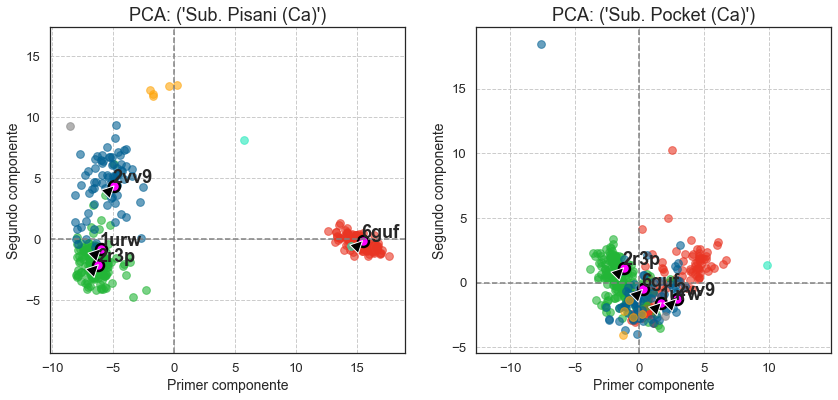

In [31]:
fig = plt.figure(figsize=(14, 6))

labels_confs = df_cdk2_labels.Labels_conf
subsecuencias = {'Sub. Pisani': pisiani_residues, 'Sub. Pocket': pocket_residues}

for i, name in enumerate(subsecuencias):
    pca_obj = PCA(copy=True, n_components=2)
    pca_all_Ca = get_pca(pca_obj = pca_obj, traj = traj_crystals, 
                    atom_mask=F"(:{subsecuencias[name]})&(@CA)",
                    standarize= False)
    plt.subplot(1, 2, i + 1)
    plot_mds(mds_obj = pca_all_Ca.T, titulo = F"PCA: ('{name} (Ca)')", 
             list_of_labels = labels_confs, 
             key_structures= confs_vrd, df_conf_indexes = df_cdk2_labels.index)

### Zoom al PCA con los *Ca* de los residuos del pocket

(-6, 7)

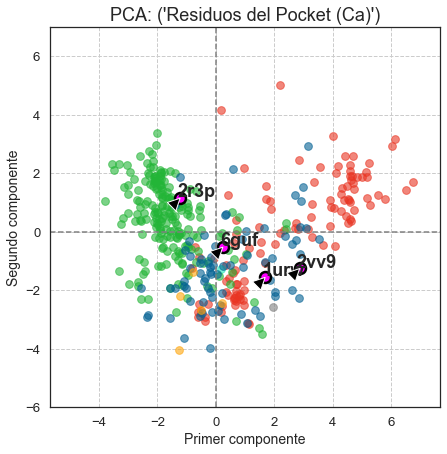

In [32]:
fig = plt.figure(figsize=(7, 7))

labels_confs = df_cdk2_labels.Labels_conf
pca_obj = PCA(copy=True, n_components=2)
pca_all_Ca = get_pca(pca_obj = pca_obj, traj = traj_crystals, 
                atom_mask=F"(:{pocket_residues})&(@CA)", standarize= False)
plot_mds(mds_obj = pca_all_Ca.T, titulo = F"PCA: ('Residuos del Pocket (Ca)')", list_of_labels = labels_confs, 
         key_structures= confs_vrd, df_conf_indexes = df_cdk2_labels.index, equal_axis = True)
plt.xlim(-5, 7)
plt.ylim(-6, 7)

***
# Pendiente

In [33]:
error_

NameError: name 'error_' is not defined

In [ ]:
pca_obj = PCA(copy=True, n_components=2)
pca_all_Ca = get_pca(pca_obj= pca_obj, traj = traj_crystals, atom_mask=F"(:{pocket_residues})&(@CA)",
                    standarize= True)

fig = plt.figure(figsize=(8, 8))
plot_mds(mds_obj = pca_all_Ca.T, titulo = F"PCA", 
             list_of_labels = df_cdk2_labels.Labels_conf, 
             key_structures= confs_vrd, df_conf_indexes = df_cdk2_labels.index)

In [ ]:
pca_obj = TSNE(n_components=2)
pca_all_Ca = get_pca(pca_obj= pca_obj, traj = traj_crystals, atom_mask=F"(:{pocket_residues})&(@CA)",
                    standarize=True)

fig = plt.figure(figsize=(8, 8))
plot_mds(mds_obj = pca_all_Ca.T, titulo = F"PCA", 
             list_of_labels = df_cdk2_labels.Labels_conf, 
             key_structures= confs_vrd, df_conf_indexes = df_cdk2_labels.index)

## Otros métodos de reducción dimensional (PCA y  t-SNE) sobre POVME

Cargamos la matriz binaria con los resultados de POVME.  
La matriz posee 402 filas (1 por conformación), y 2709 columnas.  
Cada fila es un vector binario de 2709 posibles puntos que corresponden al espacio que puede ocupar la cavidad del pocket de una conformación.

In [ ]:
# Carga de la matriz 
vec_points_mtx = np.load('./B_DATOS/povme_402_crys_pocket_points.npy')
vec_points_mtx.shape

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
X = vec_points_mtx

std_pca = PCA(n_components=2)
a = std_pca.fit_transform(X)

fig = plt.figure(figsize=(6, 6))
plot_mds(mds_obj = a.T, titulo = F"PCA POVME", list_of_labels = df_cdk2_labels.Labels_conf,  
         key_structures= confs_vrd, df_conf_indexes = df_cdk2_labels.index)

In [ ]:
X_std = StandardScaler().fit_transform(vec_points_mtx)
X_std.shape

std_pca = PCA(n_components=2)
a = std_pca.fit_transform(X_std)

fig = plt.figure(figsize=(6, 6))
plot_mds(mds_obj = a.T, titulo = F"PCA POVME", 
             list_of_labels = df_cdk2_labels.Labels_conf,  key_structures= confs_vrd,
              df_conf_indexes = df_cdk2_labels.index)
plt.xlim([-30, 50])
plt.ylim([-30, 50])

In [ ]:
type(df_cdk2_labels.AUC_vrd_16x > 0.8)

In [ ]:
type(df_cdk2_labels.Labels_conf)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NeighborhoodComponentsAnalysis

X = vec_points_mtx
y = (df_cdk2_labels.AUC_vrd_8x > 0.8)

clf = NeighborhoodComponentsAnalysis(n_components=2)
a = clf.fit_transform(X, y)


fig = plt.figure(figsize=(6, 6))
plot_mds(mds_obj = a.T, titulo = F"LDA POVME", 
             list_of_labels = df_cdk2_labels.Labels_conf,  key_structures= confs_vrd,
              df_conf_indexes = df_cdk2_labels.index)

In [ ]:
from sklearn.manifold import TSNE
X = vec_points_mtx

std_pca = TSNE(n_components=2, perplexity = 10)
a = std_pca.fit_transform(X)

fig = plt.figure(figsize=(6, 6))
plot_mds(mds_obj = a.T, titulo = F"PCA POVME", 
             list_of_labels = df_cdk2_labels.Labels_conf,  key_structures= confs_vrd,
              df_conf_indexes = df_cdk2_labels.index)

In [ ]:
from scipy.spatial.distance import pdist, squareform

tanimoto_D = pdist(vecPosMatrix, 'jaccard')
tanimoto_D = squareform(tanimoto_D)

mds = cMDS(tanimoto_D) # Se convertirá a matriz de distancia
plot_mds(mds_obj = mds[0], titulo = F"Tanimoto", 
         list_of_labels = df_cdk2_labels.Labels_conf, 
         key_structures= confs_vrd, df_conf_indexes = df_cdk2_labels.index)